# 01 — Data Ingestion & Validation

Fetches stock prices (yfinance), macro indicators (FRED), and FOMC event data.
Builds and validates the master dataframe. Exports `prices_daily.csv` for Tableau.

In [10]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.data_fetcher import (
    fetch_stock_prices,
    fetch_macro_data,
    load_fomc_events,
    get_hike_events,
    build_master_dataframe,
    export_prices_for_tableau,
    MAG7_TICKERS,
)

sns.set_theme(style='whitegrid')
%matplotlib inline

## 1. Fetch Stock Prices

In [2]:
prices = fetch_stock_prices()
print(f"Shape: {prices.shape}")
print(f"Date range: {prices.index.min()} to {prices.index.max()}")
print(f"Tickers: {list(prices.columns)}")
print(f"\nNull counts:\n{prices.isnull().sum()}")
prices.tail()

[*********************100%***********************]  9 of 9 completed


Shape: (2795, 9)
Date range: 2015-01-02 00:00:00 to 2026-02-12 00:00:00
Tickers: ['AAPL', 'AMZN', 'GOOGL', 'META', 'MSFT', 'NVDA', 'TSLA', '^GSPC', '^VIX']

Null counts:
Ticker
AAPL     1
AMZN     1
GOOGL    1
META     1
MSFT     1
NVDA     1
TSLA     1
^GSPC    1
^VIX     0
dtype: int64


Ticker,AAPL,AMZN,GOOGL,META,MSFT,NVDA,TSLA,^GSPC,^VIX
date,,,,,,,,,
2026-02-06,277.859985,210.320007,322.859985,661.460022,401.140015,185.410004,411.109985,6932.299805,20.370001
2026-02-09,274.619995,208.720001,324.320007,677.219971,413.600006,190.039993,417.320007,6964.819824,17.360001
2026-02-10,273.679993,206.960007,318.579987,670.719971,413.269989,188.539993,425.209991,6941.810059,17.790001
2026-02-11,275.500000,204.080002,310.959991,668.690002,404.369995,190.050003,428.269989,6941.470215,17.650000
2026-02-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.299999


## 2. Fetch Macro Data (FRED)

In [3]:
# Requires FRED_API_KEY in .env file
# Register free at: https://fred.stlouisfed.org/docs/api/api_key.html
macro = fetch_macro_data()
print(f"Shape: {macro.shape}")
print(f"Date range: {macro.index.min()} to {macro.index.max()}")
print(f"\nColumns: {list(macro.columns)}")
print(f"\nNull counts:\n{macro.isnull().sum()}")
macro.tail()

Shape: (4059, 5)
Date range: 2015-01-01 00:00:00 to 2026-02-10 00:00:00

Columns: ['fed_rate', 'cpi', 'treasury_10y', 'gdp_growth', 'cpi_yoy']

Null counts:
fed_rate        3868
cpi             3870
treasury_10y     212
gdp_growth         0
cpi_yoy         4059
dtype: int64


,fed_rate,cpi,treasury_10y,gdp_growth,cpi_yoy
date,,,,,
2026-02-06,NaN,NaN,4.22,4.4,NaN
2026-02-07,NaN,NaN,4.22,4.4,NaN
2026-02-08,NaN,NaN,4.22,4.4,NaN
2026-02-09,NaN,NaN,4.22,4.4,NaN
2026-02-10,NaN,NaN,4.16,4.4,NaN


## 3. Load FOMC Events

In [4]:
fomc = load_fomc_events()
hikes = get_hike_events(fomc)

print(f"Total rate changes: {len(fomc)}")
print(f"  Hikes: {len(fomc[fomc['direction'] == 'hike'])}")
print(f"  Cuts:  {len(fomc[fomc['direction'] == 'cut'])}")
print(f"\nHike cycles:")
print(f"  2015-2018: {len(hikes[(hikes['date'] >= '2015-01-01') & (hikes['date'] <= '2018-12-31')])} hikes")
print(f"  2022-2023: {len(hikes[(hikes['date'] >= '2022-01-01') & (hikes['date'] <= '2023-12-31')])} hikes")
fomc

Total rate changes: 28
  Hikes: 20
  Cuts:  8

Hike cycles:
  2015-2018: 9 hikes
  2022-2023: 11 hikes


,date,rate_before,rate_after,change_bps,direction
0,2015-12-16,0.25,0.50,25,hike
1,2016-12-14,0.50,0.75,25,hike
2,2017-03-15,0.75,1.00,25,hike
3,2017-06-14,1.00,1.25,25,hike
4,2017-12-13,1.25,1.50,25,hike
5,2018-03-21,1.50,1.75,25,hike
6,2018-06-13,1.75,2.00,25,hike
7,2018-09-26,2.00,2.25,25,hike
8,2018-12-19,2.25,2.50,25,hike
9,2019-07-31,2.50,2.25,-25,cut


## 4. Build Master Dataframe

In [5]:
master = build_master_dataframe(prices, macro, fomc)
print(f"Shape: {master.shape}")
print(f"Columns: {list(master.columns)}")
print(f"\nRate regime distribution:")
print(master['rate_regime'].value_counts())
print(f"\nFOMC event days (T+1): {master['fomc_event'].sum()}")
master.tail()

Shape: (2795, 25)
Columns: ['AAPL', 'AMZN', 'GOOGL', 'META', 'MSFT', 'NVDA', 'TSLA', '^GSPC', '^VIX', 'fed_rate', 'cpi', 'treasury_10y', 'gdp_growth', 'cpi_yoy', 'AAPL_return', 'AMZN_return', 'GOOGL_return', 'META_return', 'MSFT_return', 'NVDA_return', 'TSLA_return', '^GSPC_return', '^VIX_return', 'rate_regime', 'fomc_event']

Rate regime distribution:
rate_regime
hiking     1540
cutting    1013
holding     242
Name: count, dtype: int64

FOMC event days (T+1): 28


Ticker,AAPL,AMZN,GOOGL,META,MSFT,NVDA,TSLA,^GSPC,^VIX,fed_rate,...,AMZN_return,GOOGL_return,META_return,MSFT_return,NVDA_return,TSLA_return,^GSPC_return,^VIX_return,rate_regime,fomc_event
date,,,,,,,,,,,,,,,,,,,,,
2026-02-06,277.859985,210.320007,322.859985,661.460022,401.140015,185.410004,411.109985,6932.299805,20.370001,NaN,...,-0.055548,-0.025328,-0.013056,0.018975,0.078718,0.034994,0.019696,-0.064309,cutting,False
2026-02-09,274.619995,208.720001,324.320007,677.219971,413.600006,190.039993,417.320007,6964.819824,17.360001,NaN,...,-0.007607,0.004522,0.023826,0.031061,0.024972,0.015106,0.004691,-0.147766,cutting,False
2026-02-10,273.679993,206.960007,318.579987,670.719971,413.269989,188.539993,425.209991,6941.810059,17.790001,NaN,...,-0.008432,-0.017699,-0.009598,-0.000798,-0.007893,0.018906,-0.003304,0.024770,cutting,False
2026-02-11,275.500000,204.080002,310.959991,668.690002,404.369995,190.050003,428.269989,6941.470215,17.650000,NaN,...,-0.013916,-0.023919,-0.003027,-0.021536,0.008009,0.007196,-0.000049,-0.007870,cutting,False
2026-02-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.299999,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.019830,holding,False


## 5. Visualizations

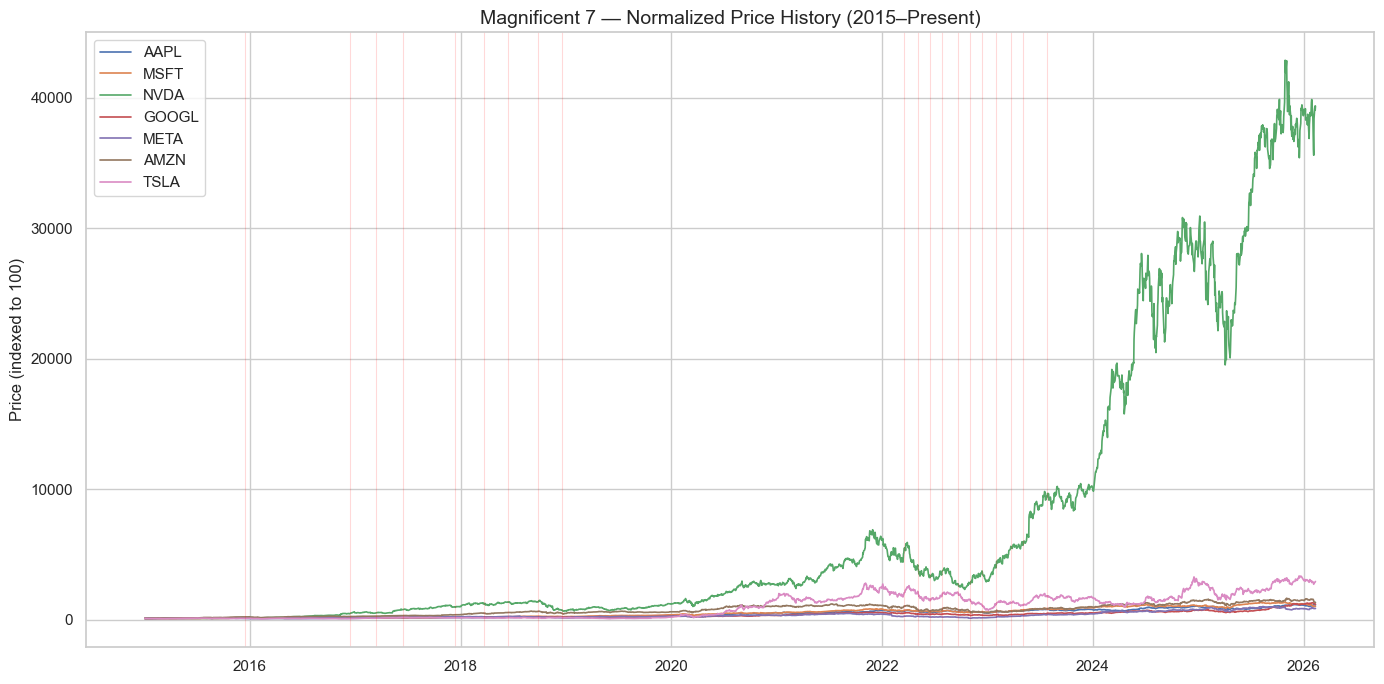

In [6]:
# Mag 7 price history (normalized to 100 at start)
fig, ax = plt.subplots(figsize=(14, 7))

for ticker in MAG7_TICKERS:
    normalized = (prices[ticker] / prices[ticker].dropna().iloc[0]) * 100
    ax.plot(normalized, label=ticker, linewidth=1.2)

# Add vertical lines for rate hikes
for _, row in hikes.iterrows():
    ax.axvline(row['date'], color='red', alpha=0.15, linewidth=0.8)

ax.set_title('Magnificent 7 — Normalized Price History (2015–Present)', fontsize=14)
ax.set_ylabel('Price (indexed to 100)')
ax.legend(loc='upper left')
ax.set_xlabel('')
plt.tight_layout()
plt.show()

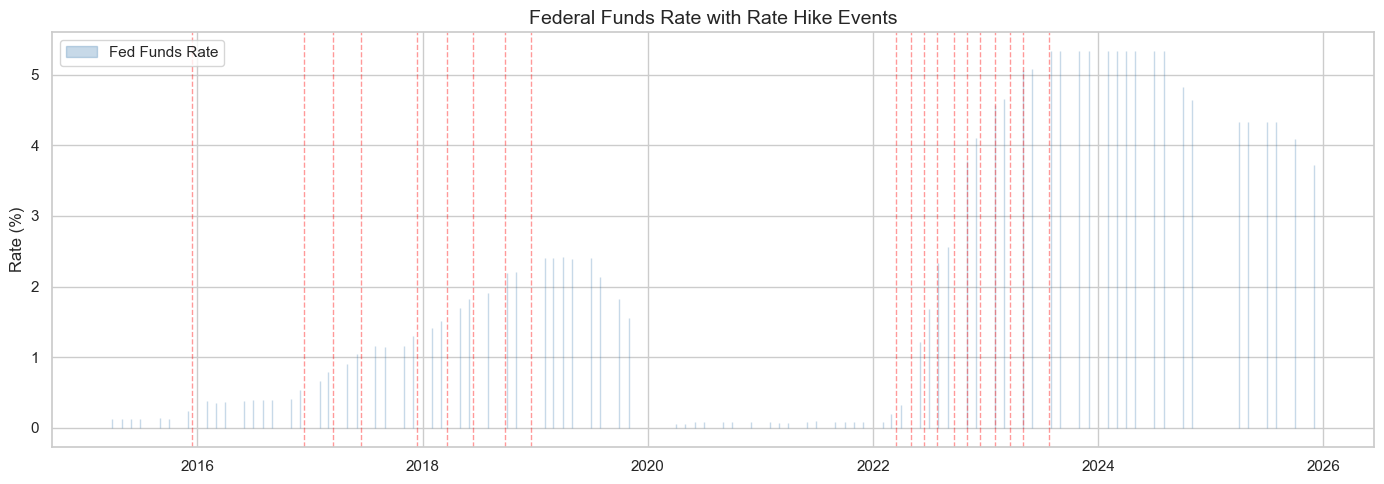

In [7]:
# Fed Funds Rate timeline with rate hike markers
fig, ax1 = plt.subplots(figsize=(14, 5))

ax1.fill_between(master.index, master['fed_rate'], alpha=0.3, color='steelblue', label='Fed Funds Rate')
ax1.plot(master.index, master['fed_rate'], color='steelblue', linewidth=1.5)

for _, row in hikes.iterrows():
    ax1.axvline(row['date'], color='red', alpha=0.4, linewidth=1, linestyle='--')

ax1.set_title('Federal Funds Rate with Rate Hike Events', fontsize=14)
ax1.set_ylabel('Rate (%)')
ax1.legend(loc='upper left')
plt.tight_layout()
plt.show()

## 6. Validation Checks

In [8]:
# Validation
print("=== Validation Checks ===")

# No duplicate dates
assert not prices.index.duplicated().any(), "Duplicate dates in prices!"
print("[PASS] No duplicate dates in prices")

# All Mag 7 tickers present
for t in MAG7_TICKERS:
    assert t in prices.columns, f"Missing ticker: {t}"
print(f"[PASS] All {len(MAG7_TICKERS)} Mag 7 tickers present")

# Date range starts from 2015
assert prices.index.min().year == 2015, "Prices don't start from 2015"
print(f"[PASS] Price data starts from {prices.index.min().date()}")

# Macro data has key columns
for col in ['fed_rate', 'cpi', 'treasury_10y']:
    assert col in macro.columns, f"Missing macro column: {col}"
print(f"[PASS] All macro columns present: {list(macro.columns)}")

# FOMC hikes count is reasonable
assert len(hikes) >= 15, f"Only {len(hikes)} hike events — expected ~20"
print(f"[PASS] {len(hikes)} hike events found")

print("\n=== All validation checks passed ===")

=== Validation Checks ===
[PASS] No duplicate dates in prices
[PASS] All 7 Mag 7 tickers present
[PASS] Price data starts from 2015-01-02
[PASS] All macro columns present: ['fed_rate', 'cpi', 'treasury_10y', 'gdp_growth', 'cpi_yoy']
[PASS] 20 hike events found

=== All validation checks passed ===


## 7. Export for Tableau

In [9]:
long_df = export_prices_for_tableau(master)
long_df.head(10)

Exported 25,155 rows to /Users/thedarianwong/Developer/bigtech-fed-analysis/output/prices_daily.csv


Ticker,date,ticker,price,daily_return,fed_rate,cpi,treasury_10y,gdp_growth,cpi_yoy,rate_regime
0,2015-01-02,AAPL,24.214890,NaN,NaN,NaN,2.12,3.583333,NaN,holding
1,2015-01-02,AMZN,15.426000,NaN,NaN,NaN,2.12,3.583333,NaN,holding
2,2015-01-02,GOOGL,26.278942,NaN,NaN,NaN,2.12,3.583333,NaN,holding
3,2015-01-02,META,77.905800,NaN,NaN,NaN,2.12,3.583333,NaN,holding
4,2015-01-02,MSFT,39.858463,NaN,NaN,NaN,2.12,3.583333,NaN,holding
5,2015-01-02,NVDA,0.483011,NaN,NaN,NaN,2.12,3.583333,NaN,holding
6,2015-01-02,TSLA,14.620667,NaN,NaN,NaN,2.12,3.583333,NaN,holding
7,2015-01-02,^GSPC,2058.199951,NaN,NaN,NaN,2.12,3.583333,NaN,holding
8,2015-01-02,^VIX,17.790001,NaN,NaN,NaN,2.12,3.583333,NaN,holding
9,2015-01-05,AAPL,23.532722,-0.028171,NaN,NaN,2.04,3.566667,NaN,holding
